# Data Science Portfolio - Part II (40 marks)

This question has been created to test your statistical analysis and programming knowledge in Python. 

You are given a `csv` file, which include various data entries for each football match in **English Premier League** during the 2020-2021 season. To name a few of these entries: date, referee name, number of goals, red cards, etc. The `csv` dataset you are provided contains one row per football match. The column names are abbreviations and given as: 

```
Div = League Division
Date = Match Date (dd/mm/yy)
Time = Time of match kick off
HomeTeam = Home Team
AwayTeam = Away Team
FTHG = Full Time Home Team Goals
FTAG = Full Time Away Team Goals
FTR = Full Time Result (H=Home Win, D=Draw, A=Away Win)
HTHG = Half Time Home Team Goals
HTAG = Half Time Away Team Goals
HTR = Half Time Result (H=Home Win, D=Draw, A=Away Win)
Referee = Match Referee
HS = Home Team Shots
AS = Away Team Shots
HST = Home Team Shots on Target
AST = Away Team Shots on Target
HF = Home Team Fouls Committed
AF = Away Team Fouls Committed
HC = Home Team Corners
AC = Away Team Corners
HY = Home Team Yellow Cards
AY = Away Team Yellow Cards
HR = Home Team Red Cards
AR = Away Team Red Cards
```


In this exercise, you are asked to perform a number of operations to:

 - perform statistical analysis of the data, and

 - gain insights from the data.

In [81]:
# suggested imports
import pandas as pd
import numpy as np
import statsmodels.api as sm
import scipy
from urllib import request
import scipy.stats as stats
from statsmodels import graphics
import arviz as az
import pymc3 as pm
from pymc3 import glm
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, RocCurveDisplay, auc, roc_curve
import seaborn as sns
sns.set_style(style="darkgrid", rc={"axes.facecolor": ".9", "grid.color": ".8"})
sns.set_palette(palette="deep")
sns_c = sns.color_palette(palette="deep")

import warnings
warnings.filterwarnings("ignore")

In [82]:
module_url = f"https://raw.githubusercontent.com/oktaykarakus/cmt309-portfolio/main/EPL_season-2021.csv"
module_name = module_url.split('/')[-1]
print(f'Fetching {module_url}')
with request.urlopen(module_url) as f, open(module_name,'w') as outf:
  a = f.read()
  outf.write(a.decode('utf-8'))

df = pd.read_csv('EPL_season-2021.csv')
df = df.fillna('')

Fetching https://raw.githubusercontent.com/oktaykarakus/cmt309-portfolio/main/EPL_season-2021.csv


In [83]:
df.head(10) # check the first 10 rows

,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR
0,E0,12/09/2020,12:30,Fulham,Arsenal,0,3,A,0,1,...,2,6,12,12,2,3,2,2,0,0
1,E0,12/09/2020,15:00,Crystal Palace,Southampton,1,0,H,1,0,...,3,5,14,11,7,3,2,1,0,0
2,E0,12/09/2020,17:30,Liverpool,Leeds,4,3,H,3,2,...,6,3,9,6,9,0,1,0,0,0
3,E0,12/09/2020,20:00,West Ham,Newcastle,0,2,A,0,0,...,3,2,13,7,8,7,2,2,0,0
4,E0,13/09/2020,14:00,West Brom,Leicester,0,3,A,0,0,...,1,7,12,9,2,5,1,1,0,0
5,E0,13/09/2020,16:30,Tottenham,Everton,0,1,A,0,0,...,5,4,15,7,5,3,1,0,0,0
6,E0,14/09/2020,20:15,Brighton,Chelsea,1,3,A,0,1,...,3,5,8,13,4,3,1,0,0,0
7,E0,14/09/2020,18:00,Sheffield United,Wolves,0,2,A,0,2,...,2,4,13,7,12,5,2,1,0,0
8,E0,19/09/2020,12:30,Everton,West Brom,5,2,H,2,1,...,7,4,9,11,11,1,1,0,0,1
9,E0,19/09/2020,15:00,Leeds,Fulham,4,3,H,2,1,...,7,6,13,18,5,3,1,2,0,0


## P2.1 - Data Pre-processing and Exploratory Analysis (11 marks)

In this question, your task is to use `pandas` and other required modules to preprocess the data frame, `df`. Preprocessing will include: add/remove/recode columns in `df`. In addition, to further explore the dataset, you need to produce a number of exploratory plots. 

#### P2.1.1 - Add Booking Points Columns (1 marks) 

Sometimes, in order to better analyse any given data set, one can create a new type of feature by combining two or more existing entries of the data frame. In this question, you are asked to create a function `add_booking_pts(df)` which creates two new columns of: **Home booking points (HBP)**, and **Away booking points (ABP)** by using four existing columns of HY, AY, HR, and AR.

The details of the function `add_booking_pts(df)` are given below:

 - Takes the data frame `df` as input.
 
 - For each match, number of yellow cards is weighted with 10 points, whilst the number of red cards is with 25 points. 
 
 - Basically, the function calculates HBP and ABP columns as
    - $HBP = 10\cdot HY + 25\cdot HR$
    - $ABP = 10\cdot AY + 25\cdot AR$
 
 - These newly created arrays are added to `df`, whilst removing the columns for HY, AY, HR, and AR.
 
 - Finally, the updated `df` is returned.

In [84]:
def add_booking_pts(df): 
    df['HBP'] = pd.Series().astype(int) # home_booking_points
    df['ABP'] = pd.Series().astype(int)  # away_booking_points
    for i in range(len(df)): # for each row
        if df.loc[i, 'HBP'] == '': # if home_booking_points is empty
            df.loc[i, 'HBP'] = 0 # set to 0
        if df.loc[i, 'ABP'] == '': # if away_booking_points is empty
            df.loc[i, 'ABP'] = 0 # set to 0
        df['HBP'][i] = 10*df.loc[i, 'HY'] + 25* df.loc[i, 'HR'] # add home_booking_points
        df['ABP'][i] = 10*df.loc[i, 'AY'] + 25* df.loc[i, 'AR'] # add away_booking_points
    df.drop(columns=['HY','HR','AY','AR'], inplace=True) # drop unnecessary columns
    
    return df # return dataframe

add_booking_pts(df) # add booking points to dataframe


,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,HS,AS,HST,AST,HF,AF,HC,AC,HBP,ABP
0,E0,12/09/2020,12:30,Fulham,Arsenal,0,3,A,0,1,...,5,13,2,6,12,12,2,3,20.0,20.0
1,E0,12/09/2020,15:00,Crystal Palace,Southampton,1,0,H,1,0,...,5,9,3,5,14,11,7,3,20.0,10.0
2,E0,12/09/2020,17:30,Liverpool,Leeds,4,3,H,3,2,...,22,6,6,3,9,6,9,0,10.0,0.0
3,E0,12/09/2020,20:00,West Ham,Newcastle,0,2,A,0,0,...,15,15,3,2,13,7,8,7,20.0,20.0
4,E0,13/09/2020,14:00,West Brom,Leicester,0,3,A,0,0,...,7,13,1,7,12,9,2,5,10.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,E0,23/05/2021,16:00,Liverpool,Crystal Palace,2,0,H,1,0,...,19,5,5,4,10,8,14,1,20.0,20.0
376,E0,23/05/2021,16:00,Man City,Everton,5,0,H,2,0,...,21,8,11,3,8,10,7,5,20.0,20.0
377,E0,23/05/2021,16:00,Sheffield United,Burnley,1,0,H,1,0,...,12,10,3,3,11,1,8,9,30.0,10.0
378,E0,23/05/2021,16:00,West Ham,Southampton,3,0,H,2,0,...,14,17,7,5,5,9,2,3,0.0,30.0


#### P2.1.2 - Convert Table Colums into Digits (2 marks) 

When reading in the dataframe, one can see that it contains some textual data which will not be relevant for the numerical analyses in Question 1. Therefore, implement a function `convert_results(df)` 

1. (1 mark) to convert **half-time results (HTR)** and **full-time results (FTR)** into numerical data. The details of the function are given below: 
 
- HTR and FTR columns include string values of `'H'`, `'D'` and `'A'`. These string corresponds to the cases below:
    - `'H'`: Home team win

    - `'D'`: Draw

    - `'A'`: Away team win

- The function `convert_results(df)` will replace `'H'`, `'D'` and `'A'` values with `int` type values of of 1, 0, -1, respectively.

2. (1 mark) to convert **Time** column into `float` type values in interval of $[0, 24)$. Since an hour has 60 minutes, a 15-minute interval corresponds to quarter of an hour (i.e 0.25 hours). Considering this, some examples can be given:
 
- `'12.30'` will be `12.5`, or 
 
- `'18.15'` will be `18.25` or 
 
- `'17.00'` will be `17.0`
 
The function `convert_results(df)` should return the updated data frame `df`.

In [85]:
def convert_results(df):
    HTR_FTR_dict = {'H': 1, 'D': 0, 'A': -1} # dictionary for converting HTR and FTR to 1, 0, -1
    df['HTR'] = df['HTR'].map(HTR_FTR_dict) # map HTR and FTR to 1, 0, -1
    df['FTR'] = df['FTR'].map(HTR_FTR_dict) # map HTR and FTR to 1, 0, -1
    
    df['HTR'] = df['HTR'].astype(int) # convert HTR and FTR to int
    df['FTR'] = df['FTR'].astype(int) # convert HTR and FTR to int

    time_hour = 0 # time_hour
    time_min = 0 # time_min

    for i in range(len(df)):
        time_hour = df['Time'][i].split(':')[0] # split time into hour and minute
        time_min = df['Time'][i].split(':')[1] # split time into hour and minute
        df['Time'][i] = int(time_hour) + int(time_min)/60 # add time_hour and time_min to get total time

    # convert time to float for regression
    df['Time'] = df['Time'].astype(float)
    
    return df # return dataframe 


convert_results(df) # convert results to 1, 0, -1

,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,HS,AS,HST,AST,HF,AF,HC,AC,HBP,ABP
0,E0,12/09/2020,12.5,Fulham,Arsenal,0,3,-1,0,1,...,5,13,2,6,12,12,2,3,20.0,20.0
1,E0,12/09/2020,15.0,Crystal Palace,Southampton,1,0,1,1,0,...,5,9,3,5,14,11,7,3,20.0,10.0
2,E0,12/09/2020,17.5,Liverpool,Leeds,4,3,1,3,2,...,22,6,6,3,9,6,9,0,10.0,0.0
3,E0,12/09/2020,20.0,West Ham,Newcastle,0,2,-1,0,0,...,15,15,3,2,13,7,8,7,20.0,20.0
4,E0,13/09/2020,14.0,West Brom,Leicester,0,3,-1,0,0,...,7,13,1,7,12,9,2,5,10.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,E0,23/05/2021,16.0,Liverpool,Crystal Palace,2,0,1,1,0,...,19,5,5,4,10,8,14,1,20.0,20.0
376,E0,23/05/2021,16.0,Man City,Everton,5,0,1,2,0,...,21,8,11,3,8,10,7,5,20.0,20.0
377,E0,23/05/2021,16.0,Sheffield United,Burnley,1,0,1,1,0,...,12,10,3,3,11,1,8,9,30.0,10.0
378,E0,23/05/2021,16.0,West Ham,Southampton,3,0,1,2,0,...,14,17,7,5,5,9,2,3,0.0,30.0


#### P2.1.3 - Fair Play League Table (4 marks) 

Write a function `create_fair_play_table(df)` to depict a **barplot with horizontal bars** representing *total booking points*. The module `seaborn` and its corresponding methods and attributes must be used in this question.

Produce a bar for each team (use the HBP and ABP columns) and plot them in increasing order. The team with the top bar (*i.e.* lowest HBP+ABP) will represent the Fair Play League Champion. Also, print the statement below

```
The champions of the 2020-2021 Fair Play League is {locate the team here}.
```

![](https://drive.google.com/uc?export=view&id=11gYwhu-1D6dxEcmXK31pL5Zcop497w9i)

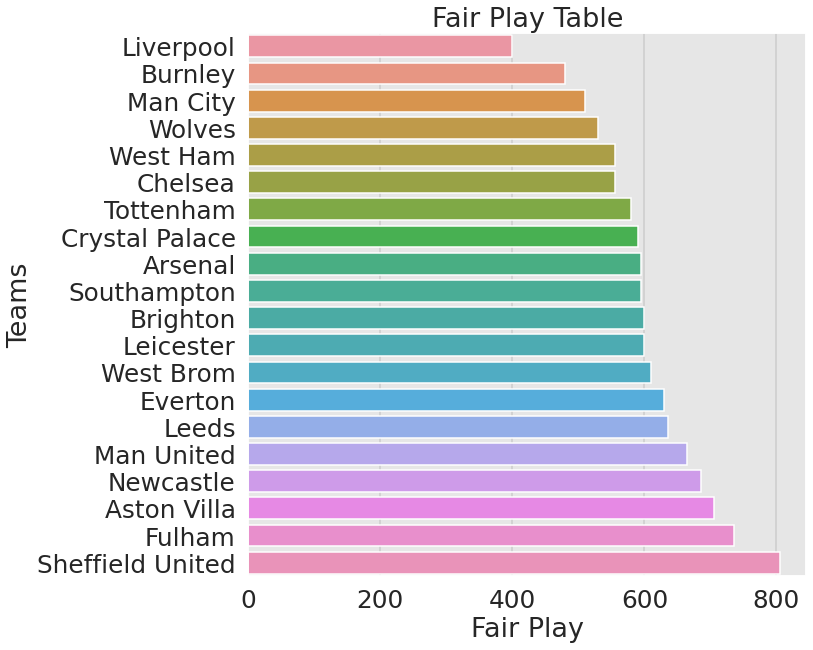

The champions of the 2020-2021 Fair Play League is Liverpool


In [86]:
def create_fair_play_table(df):
    fp_dict = {} # create a dictionary
    for i in range(len(df)): # for each row
        fp_dict[df['HomeTeam'][i]] = 0 # add home team to dictionary
        fp_dict[df['AwayTeam'][i]] = 0 # add away team to dictionary
    
    for i in range(len(df)): # for each row
        fp_dict[df['HomeTeam'][i]] += df['HBP'][i] # add home_booking_points to home team
        fp_dict[df['AwayTeam'][i]] += df['ABP'][i] # add away_booking_points to away team

    df_fp = pd.DataFrame.from_dict(fp_dict, orient='index') # create a dataframe from dictionary
    df_fp.columns = ['FP'] # add column name
    df_fp.sort_values(by='FP', ascending=True, inplace=True) # sort dataframe by FP
    df_fp.reset_index(inplace=True) # reset index
    df_fp.rename(columns={'index':'Teams'}, inplace=True) # rename column

    sns.set_theme(style="darkgrid", rc={"axes.facecolor": ".9", "grid.color": ".8"})
    sns.set_palette(palette="deep")
    sns_c = sns.color_palette(palette="deep")
    sns.set_context(context="talk", font_scale=1.5)
    fig = plt.figure(figsize=(10,10))
    ax = sns.barplot(x='FP', y='Teams', data=df_fp) # plot dataframe
    ax.set_title('Fair Play Table') # add title
    ax.set_xlabel('Fair Play') # add xlabel
    ax.set_ylabel('Teams') # add ylabel
    
      
    plt.show() # show plot

    print('The champions of the 2020-2021 Fair Play League is ' + df_fp.iloc[0,0]) # print the champion
    
    fig.savefig('Fair Play Table.png') # save plot

       
    return df_fp # return dataframe    

df_fp = create_fair_play_table(df)

### P2.1.4 - Expected number of goals vs. Exact scores (4 marks) 

Expected number of goals (xG) is a predictive model used to assess every goal-scoring chance, and the likelihood of scoring. Nowadays, xG has a strong algorithm behind it, but in this example, we will assume two basic models to calculate the xG of any football team for any game:
 
 - $xG_1 = 0.1 \cdot S$
 
 - $xG_2 = 0.1 \cdot S + 0.05\cdot SoT$

where $S$ and $SoT$ is the total number of shoots and total shoots on target, respectively.

Write a function `xG_plot(df)` to plot $xG_1$, $xG_2$ and exact number of goals scored by a randomly selected football team for whole 38 game weeks. 

This exploratory analysis will depict two sub-plots:
 
 1. Running mean of all three variables (xG1, xG2 and Goals). Running mean shows the average of a value up to a time step. For example: running mean of xG1 for week 5 is $\frac{1}{5}\sum_{i=0}^{4}xG1_{i}$, or similarly for week 17 is $\frac{1}{17}\sum_{i=0}^{16}xG1_{i}$.

 2. Cumulative sum of all three variables (xG1, xG2 and Goals). (Hint: `np.cumsum()`)

Use different colours, line styles, legends, etc. to make the exploratory analysis more understandable. The function also returns calculated xGs for the randomly selected team in a `dict` type object of form `{team : (xG1, xG2)}`

![](https://drive.google.com/uc?export=view&id=1Y3uSzRQaKumgoKoNdkohYBhpgBrOkYeO)

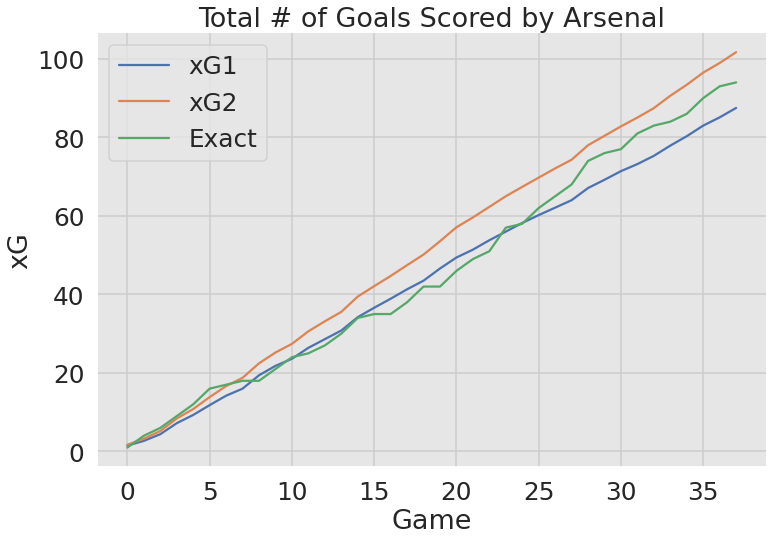

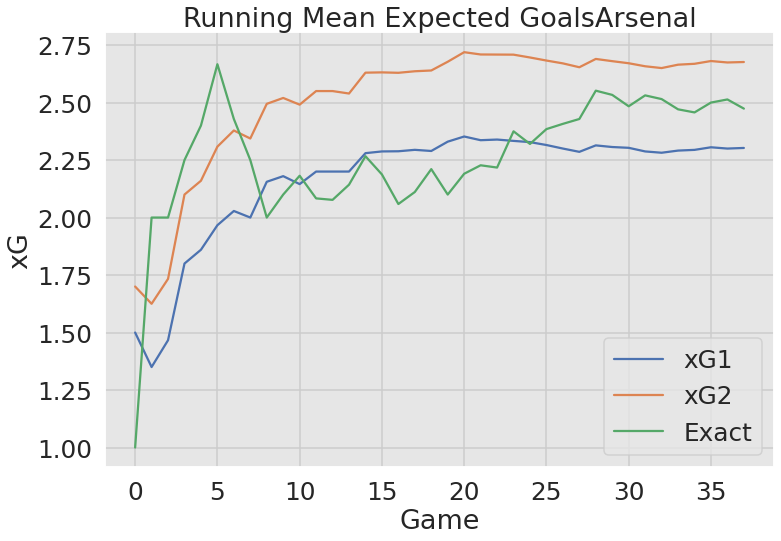

In [98]:

def xG_plot(df):
    df_xG = df[['Date','HomeTeam', 'AwayTeam', 'HS', 'AS', 'HST', 'AST','FTHG','FTAG']] # create a dataframe with necessary columns
    df_xG.dropna(inplace=True) # drop rows with NaN
    
    
    df_xG.rename(columns={'HomeTeam':'Home', 'AwayTeam':'Away'}, inplace=True) # rename columns
    df_xG.rename(columns={'HS':'Home_Shots', 'AS':'Away_Shots', 'HST':'Home_Shots_Target', 'AST':'Away_Shots_Target', 'FTHG':'Home_Score', 'FTAG':'Away_Score'}, inplace=True) # rename columns
    
    # Add all home team and away team names in a list
    team_list = []
    for i in range(len(df_xG)):
        team_list.append(df_xG.iloc[i,1])
        team_list.append(df_xG.iloc[i,2])
        
    team_list = list(set(team_list)) # remove duplicates

    # randomly choose one team from the list
    team_name = team_list[np.random.randint(0,len(team_list))]
    
       

    for i in range(len(df_xG)): # for each row
        
        if((df_xG.loc[i, 'Home'] == team_name) or (df_xG.loc[i, 'Away'] == team_name)): # if home or away team is the randomly chosen team
            df_xG.loc[i, 'Team'] = team_name # add team name
         
        else: # if home or away team is not Liverpool FC
            df_xG.loc[i, 'Team'] = "drop" # drop row
    
    df_xG = df_xG[df_xG['Team'] != "drop"] # drop rows with "drop"
    df_xG.drop(columns=['Home','Away'], inplace=True) # drop index

    # Convert string into date
    df_xG['Date'] = pd.to_datetime(df_xG['Date'])
    
    # Create new column with date
    df_xG['Date'] = df_xG['Date'].dt.date
    
    # Sort columns index by date    
    df_xG = df_xG.sort_values(by='Date')
    
    # Create a dataframe with only the columns we need
    df_xG = df_xG[['Date','Team','Home_Shots','Away_Shots','Home_Shots_Target','Away_Shots_Target','Home_Score','Away_Score']]

    # # reset index
    df_xG.reset_index(inplace=True)
    df_xG.drop(columns=['index'], inplace=True)

    
    for i in range(len(df_xG)): # for each row
        df_xG.loc[i, 'xG1'] = 0.1 * (df_xG.loc[i, 'Home_Shots'] + df_xG.loc[i, 'Away_Shots']) # add xG1
        df_xG.loc[i, 'xG2'] = 0.1 * (df_xG.loc[i, 'Home_Shots'] + df_xG.loc[i, 'Away_Shots']) + 0.05 * (df_xG.loc[i, 'Home_Shots_Target'] + df_xG.loc[i, 'Away_Shots_Target']) # add xG2  
        df_xG.loc[i, 'Exact'] = df_xG.loc[i, 'Home_Score'] + df_xG.loc[i, 'Away_Score'] # add Exact

    df_xG.drop(columns=['Home_Shots','Away_Shots','Home_Shots_Target','Away_Shots_Target','Home_Score','Away_Score'], inplace=True) # drop columns
    df_xG.rename(columns={'xG1':'xG1_Exact', 'xG2':'xG2_Exact'}, inplace=True) # rename columns
    df_xG.rename(columns={'Exact':'Exact_xG'}, inplace=True) # rename columns
    df_xG.rename(columns={'Team':'Team_xG'}, inplace=True) # rename columns

    # Calculate running total/cumulative of xG1 and xG2
    df_xG['xG1_Total'] = df_xG.groupby('Team_xG')['xG1_Exact'].cumsum()
    df_xG['xG2_Total'] = df_xG.groupby('Team_xG')['xG2_Exact'].cumsum()
    df_xG['Exact_Total'] = df_xG.groupby('Team_xG')['Exact_xG'].cumsum()

    # Calculate running mean of xG1 and xG2
    for i in range(len(df_xG)):
        df_xG.loc[i, 'xG1_Mean'] = df_xG.loc[i, 'xG1_Total'] / (i + 1)
        df_xG.loc[i, 'xG2_Mean'] = df_xG.loc[i, 'xG2_Total'] / (i + 1)
        df_xG.loc[i, 'Exact_Mean'] = df_xG.loc[i, 'Exact_Total'] / (i + 1)


    # Plot running total/cumulative of xG1 and xG2
    plt.figure(figsize=(12,8))
    plt.plot(df_xG['xG1_Total'], label='xG1')
    plt.plot(df_xG['xG2_Total'], label='xG2')
    plt.plot(df_xG['Exact_Total'], label='Exact')
    plt.legend()
    plt.title('Total # of Goals Scored by ' + team_name)
    plt.xlabel('Game')
    plt.ylabel('xG')

    # plot running mean of xG1 and xG2
    plt.figure(figsize=(12,8))
    plt.plot(df_xG['xG1_Mean'], label='xG1')
    plt.plot(df_xG['xG2_Mean'], label='xG2')
    plt.plot(df_xG['Exact_Mean'], label='Exact')
    plt.legend()
    plt.title('Running Mean Expected Goals' + team_name)
    plt.xlabel('Game')
    plt.ylabel('xG')

    


    
    xG1 = df_xG[df_xG['Team_xG'] == team_name]['xG1_Mean'].iloc[-1]
    xG2 = df_xG[df_xG['Team_xG'] == team_name]['xG2_Mean'].iloc[-1]
        
    return {team_name:(xG1, xG2)} # just for an example. your result might differ from this definition.
xG = xG_plot(df)

## P2.2 - Statistical Analysis (29 marks)

#### P2.2.1 - Model selection for Regression Analysis (9 marks)

In this question, we construct a regression analyses to investigate how well FTHG (or FTAG) can be predicted from the other variables in the dataframe. The objective of this question is to derive a sparse model (linear and polynomial) with fewer variables. 

#### P2.2.1.1 - Variable Selection for Linear Regression (5 marks)



In **variable selection** ('variable' means the same as 'predictor'), variables get iteratively added or removed from the regression model. Once finished, the model typically contains only a subset of the original variables. It makes it easier to interpret the model, and in some cases it makes it generalise better to new data. 

To perform variable selection, create a function `select_variable(df, main_pred, main_target, alpha)`, where 
 
 - `main_pred` is a dictionary of variables. For this analysis, firstly, either all Home or Away teams will be marked and the predictors given below will be used

  - Home: [Time, FTR, HTHG, HTR, HS, HST, HF, HC, HBP]
  
  - Away: [Time, FTR, HTAG, HTR, AS, AST, AF, AC, ABP]. 
 
 - `main_target` is the variable for the regression, Home: FTHG (or Away: FTAG)
 
 - `alpha` is the significance level for selecting significant predictors

The function should return

 - `main_pred` is the dictionary which stores the selected subset of initial `main_pred` both for home and away teams, in a format of `main_pred = {'Home': [... selected predictors here ...], 'Away': [... selected predictors here ...]}`.

To calculate regression fits and $p$-values you will use `statsmodels`. The general procedure follows two stages:

 - Stage 1 (adding predictors): you build a model by adding variables one after the other. You keep adding variables that increase the **adjusted $R^2$** value (provided by `statsmodels` package). 
  
  - Start with an empty set of variables
  
  - Fit multiple one-variable regression models. In each iteration, use one of the variables provided in predictors. The variable that leads to the largest increase in adjusted $R^2$ is added to the model.
  
  - Now proceed by adding a second variable into the model. Starting from the remaining variables, again choose the variable that leads to the largest increase in adjusted $R^2$.
  
  - Continue in the same way for the third, fourth, … variable.
  
  - You are finished when there is no variable left that increases adjusted $R^2$.
 
 - Stage 2 (removing non-significant predictors): if any of the utilised predictors are not significant, you need to remove them. Keep removing variables until all variables in the model are significant.

  - Start by fitting a model using the variables that have been added to the model in Stage 1.
  
  - If there is a variable that is not significant, remove the variable with the largest $p$-value and fit the model again with the reduced set of variables.
  
  - Keep removing variables and re-fitting the model until all remaining variables are significant.
  
  - The remaining significant variables are the output of your function.

In [99]:
def select_variable(df, main_pred, main_target, alpha):     
    var = {'Home': [], 'Away' : []}  # list of variables 
    for x in main_pred: # loop through each category
        last_rsq = 0 # initialize last rsq
        while len(main_pred[x])>0: # while there are still variables to add
            curr_rsq = 0 # initialize current rsq
            y = None # initialize y
            for i in range(len(main_pred[x])): # loop through each variable
                feat = var[x] + [main_pred[x][i]] # add variable to list
                rsq = sm.OLS.from_formula(main_target[x] + ' ~ ' + '+'.join(feat), data=df).fit().rsquared_adj # calculate rsq
                if rsq > curr_rsq:  # if rsq is higher than current rsq
                    curr_rsq = rsq # set current rsq to higher rsq
                    y = main_pred[x][i] # set y to variable
            if curr_rsq > last_rsq: # if current rsq is higher than last rsq
                last_rsq = curr_rsq # set last rsq to current rsq
                var[x].append(y) # add variable to list
                main_pred[x].remove(y) # remove variable from list
            else: # if current rsq is not higher than last rsq
                break # break loop
    
    
    for key in var:
        while True:

            highest_p = 0
            highest_var = None

            if len(var[key]) > 0:
                p_values = sm.OLS.from_formula(main_target[key] + ' ~ ' + '+'.join(var[key]), data=df).fit().pvalues
                p_values = p_values.to_dict()
                for p_key in p_values:
                    
                    if p_key not in var[key]:
                        continue

                    if p_values[p_key] > highest_p:
                        highest_p = p_values[p_key]
                        highest_var = p_key

                if highest_p > alpha and highest_var:
                    var[key].remove(highest_var)
                else:
                    break

                  
        

                    
        
    return var  # return list of variables     

main_pred = {'Home': ['Time', 'FTR', 'HTHG', 'HTR', 'HS', 'HST', 'HF', 'HC', 'HBP'], 'Away': ['Time', 'FTR', 'HTHG','AS','AST','AF','AC','ABP']}
main_target={'Home' : 'FTHG', 'Away': 'FTAG'}
alpha=0.05
significant_predictors = select_variable(df, main_pred, main_target, alpha)

#### P2.2.1.2 - Model Selection for Polynomial Regression (4 marks)

Often the dataset provided is not linearly separable and a simple linear regression model may not be able to derive relationships between both the independent and dependent variables. In such cases, a possible solution would be to implement polynomial regression instead (https://en.wikipedia.org/wiki/Polynomial_regression). Polynomial regression is a form of regression analysis in which the relationship between the independent variable $x$ and the dependent variable $y$ is modelled as an $n^{th}$ degree polynomial in $x$.

**Example:** Given $y$ the dependent variable, $x_1, x_2$ the independent variables, $b_0$ the bias and $b_1,b_2,...,b_n$ the weights a polynomial regression of degree 2 would have the form:

$$y = b_0 + b_1x_1 + b_2x_1^2 + b_3x_2 + b_4x_2^2$$

Implement a function `polynomial_model(df, main_pred, main_target, degrees)` which uses the selected subset of variables as an argument from the function `select_variable()`, and calculates all possible combinations of the variable set and polynomial degrees. The function `polynomial_model()` finds the degree that yields the best polynomial model (according to the adjusted R-squared metric) to predict the value of a FTHG or FTAG as in the linear regression part above.

Arguments and outputs of the function are given as

 - a dataframe `df`, 

 - a dictionary `main_pred` indicating the predictors for home and away, 
 
 - a dictionary `main_target` indicating target variable for home and away, 
 
 - a list of integers indicating the degrees to test degrees, 
 
The function should return 

 - the best fitted regression model, and best polynomial degree for home and away in a dictionary `main_predp` of format `main_predp = {'Home': (best_fit, best_degree), 'Away': (best_fit, best_degree)}`..

In [10]:
# def polynomial_model(df, main_pred, main_target, degrees):
#     # your code here
#     return main_predp

#### P2.2.2 - Predicting Match Result (5 marks)


Create a function `predict_result()` which predicts the result of **Man City - Everton** football match which was played on 23/05/2021. In order to do this, firstly crop last last 10 rows of the data frame `df` to use only the first 37 weeks (370 matches) of the season to fit your regressors.

The function `predict_result()` will use `select_variable()` and `polynomial_model()` function outputs as the best linear and polynomial regression models. Then by using these two models, it predicts the number of goals scored by Home and Away teams separately, which will lead to the result of the match. Finally, print the information below:

```
Linear regression prediction        : Man City x - y Everton
Polynomial regression prediction    : Man City a - b Everton
Correct result                      : Man City 5 - 0 Everton
```

In [11]:
# def predict_result(df, main_pred, main_predp, team1 = 'Man City', team2 = 'Everton'):
#     # your code here

#### P2.2.3 - Maximum likelihood estimation (MLE) and prediction (10 marks)

In this question, you are expected to solve a regression problem, but this time using **maximum likelihood estimation (MLE)** theory. You need to construct a regression analysis to investigate how well the **full time results (FTR)** can be predicted from the other variables of FTHG, HS, HC, AS, AC. 

#### P2.2.3.1 - ML Estimate of regression parameters (7 marks)

Create a function `ML_estimate(df_est, pred, target)` which calculates the ordinary least squares (OLS) and two MLE fits (Poisson and Probit) for the given arguments.

You need to use `statsmodels` module and its corresponding methods of `.OLS()`, `.Poisson()` and `.Probit()`.

- `df_est` is a subset of the data frame `df` which includes **randomly selected** 280 rows of `df`. The remaining 100 rows will be used in prediction application (see below).

- `pred` is a list of variables. For this analysis, OLS and other models utilise the predictors of FTHG, HS, HC, AS, AC. (Note: Depending on your implementation, you might need to add a constant to the predictors. Please see the lecture notes)

- `target` is the target variable for the regression, FTR. You need to adjust values of this column for the purpose of this question. 
 
  - FTR = 1.0 if Home team wins.
  
  - FTR = 0.0 if Away team wins or a Draw.

The function should return variables 

 - `MLE_model_fits` a `tuple` object which stores all three model fits `statsmodels` objects for OLS, Probit and Poisson.

In [100]:
# Spillting the 280 data from dataframe for training 
row, col = df.shape
train_idx = np.random.choice(row, 280, replace= False)
test_idx = np.setdiff1d(np.arange(row), train_idx, assume_unique=True)
train_df = df.iloc[train_idx, :]
# # Reset the train_df index
# train_df.reset_index(drop=True, inplace=True)

test_df = df.iloc[test_idx, :]
# # Reset the test_df index
# test_df.reset_index(drop=True, inplace=True)

# create a list of target variable FTR
target_var = ['FTR']


# Create a list of predictors FTHG, HS, HC, AS and AC
predictor_var = ['HTHG', 'HS', 'HC', 'AS', 'AC']

def ML_estimate(df_est, pred, target):

    # create a dictionary of target and predciotrs
    df_est = df_est[target + pred]

    # Encode the target variable
    df_est['FTR'] = df_est['FTR'].replace({1.0: 1.0, -1.0: 0.0}) # 1.0 is a win, 0.0 is a loss
    # drop the NA values
    df_est = df_est.dropna()

    # Convert the target variable into unit interval
    #df_est['FTR'] = df_est['FTR'].astype(int)

    
    # Print type of the first element of the FTR column
    print(type(df_est['FTR'].iloc[0]))


    # adding the intercept term
    df_est = sm.add_constant(df_est)
    
    # Fit regression models
    sm_ols = sm.OLS(df_est[target], df_est[pred]).fit()
    sm_poisson = sm.Poisson(df_est[target], df_est[pred]).fit()
    sm_probit = sm.Probit(df_est[target], df_est[pred]).fit()
    
    # create tuple of fitted models

    MLE_model_fits = (sm_ols, sm_poisson, sm_probit)
    #MLE_model_fits = [('OLS', sm_ols), ('Probit', sm_probit), ('Poisson', sm_poisson)]

    return MLE_model_fits

model = ML_estimate(train_df, predictor_var, target_var)

print(model)

<class 'numpy.int64'>
Optimization terminated successfully.
         Current function value: 0.682263
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.520765
         Iterations 6
(<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f22e9d5f0d0>, <statsmodels.discrete.discrete_model.PoissonResultsWrapper object at 0x7f22e9d5d1b0>, <statsmodels.discrete.discrete_model.BinaryResultsWrapper object at 0x7f22e9dd83d0>)


#### P2.2.3.2 - Predicting Home Win via MLE (3 marks)

Create a function `ML_predict(df_pred, MLE_model_fits)` which calculates FTR predictions for all three models of OLS, Probit and Poisson.

You need to use `statsmodels`' method for prediction: `.predict()`.

- `df_pred` is a subset of the data frame `df` which includes only a subset of 100 rows of `df`.

- `MLE_model_fits` is a `tuple` object obtained from the `ML_estimate()` function above. Unpack this argument to obtain `statsmodels` objects for all three models. 

This function should return: 

 - `df_pred`

 - `MLE_model_predictions` is a `tuple` which stores the predicted outputs for each three models.  

In [101]:
def ML_predict(df_pred, MLE_model_fits):

    # unpack the tuple
    #print(MLE_model_fits)
    (sm_ols, sm_probit, sm_poisson) = MLE_model_fits

    # Encode the target variable
    df_pred['FTR'] = df_pred['FTR'].replace({1.0: 1.0, -1.0: 0.0}) # 1.0 is a win, 0.0 is a loss

    # predict the result
    pred_ols = sm_ols.predict(df_pred[predictor_var])
    pred_probit = sm_probit.predict(df_pred[predictor_var])
    pred_poisson = sm_poisson.predict(df_pred[predictor_var])

    pred_ols2 = (pred_ols > np.mean(pred_ols)).astype(int)
    pred_probit2 = (pred_probit > np.mean(pred_probit)).astype(int)
    pred_poisson2 = (pred_poisson > np.mean(pred_poisson)).astype(int)

    # create a tuple of predicted results

    MLE_model_predictions = (pred_ols, pred_probit, pred_poisson, pred_ols2, pred_probit2, pred_poisson2)



    

    return df_pred, MLE_model_predictions

(df_pred, MLE_model_predictions) = ML_predict(test_df[predictor_var + target_var], model)


#### P2.2.4 - Evaluating Prediction Performance (5 marks)

You will now need to visualise the prediction performance of the models, and evaluate them in terms of prediction accuracy, and mean square error (MSE) metrics. For this purpose, create a function `prediction_perf(gt, MLE_model_predictions)` which evaluates the prediction performance of the reference models. Up to this point, you should have obtained

 - $N = 100$ samples of predictions from each model, stored in `MLE_model_predictions`.
 
 - The ground-truth FTR values from data frames `df`, stored in `gt`.

Assume predicted values for a given model are stored in a variable $P$ and its average is $\bar{P}$. The first performance measure will be the MSE, and will be calculated for each model from the expression below:

$$ MSE = \dfrac{1}{N}\sum_{i=0}^{N-1} (P_i - FTR_i)^2$$

In order to obtain the prediction accuracy for each model, you first should convert continuous prediction results into the binary form (either 1.0 or 0.0). The binarisation process will follow the piecewise function below:

  $$P_{binary, i} = \begin{cases} 1.0, & P_i \geq \bar{P}\\ 0.0, & \text{otherwise}  \end{cases} \quad \text{where} \quad i = 0, 1, \dots, 99$$

Then the percentage accuracy, $Acc\%$ is calculated as

$$ Acc\% = 100 - \sum_{i=0}^{99} |P_{binary, i} - FTR_i|$$

Following these, by using `sklearn` module methods `roc_curve()` and `auc()` find ROC curve parameters and AUC metric for each prediction model. 

In order to obtain performance analysis results in a neatly way, you then need to create a new `pandas` dataframe `df_results` which will be in the form of

```
+----+-------------+--------+--------+-------+
|    | Model       |   Acc% |    MSE |   AUC |
+====+=============+========+========+=======+
|  0 | OLS         |  77.00 | 0.1260 | 0.911 |
+----+-------------+--------+--------+-------+
|  1 | MLE-Probit  |  81.00 | 0.1086 | 0.911 |
+----+-------------+--------+--------+-------+
|  2 | MLE-Poisson |  76.00 | 0.1490 | 0.884 |
+----+-------------+--------+--------+-------+
```

Consequently, using `sklearn` method `RocCurveDisplay()`, the `prediction_perf()` function should 

 - `print` and `return` the data frame `df_results`.

**Marking for this question**
 - (2 marks) Calculating MSE and $Acc\%$ metrics correctly.
 - (3 marks) Creating and returning dataframe `df_results`.
 
with a condition that all these three operations are performed in a **fully working `prediction_perf()` function**.

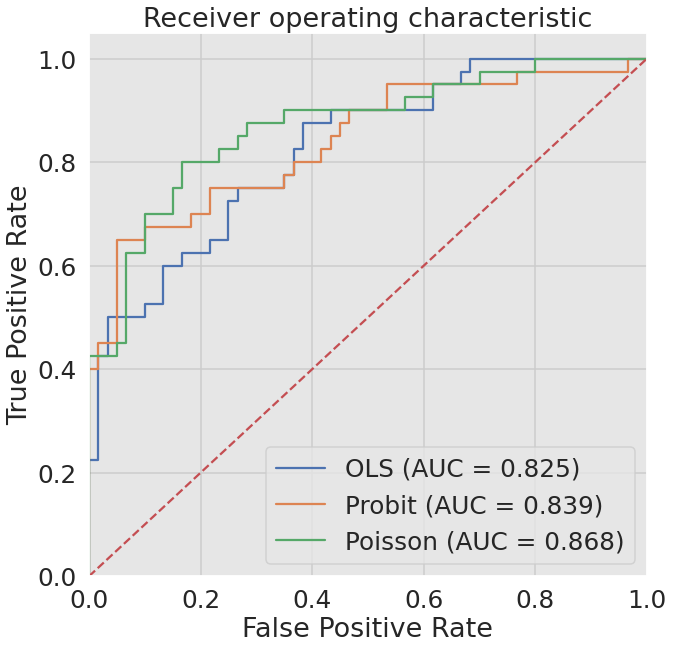

,Model,MSE,Accuracy,AUC
0,OLS,0.170,70.0,0.825
1,Probit,0.163,78.0,0.839
2,Poisson,0.148,79.0,0.868


In [103]:
from sklearn import metrics as m
def prediction_perf(gt, MLE_model_predictions):
    # unpack the tuple
    (pred_ols, pred_probit, pred_poisson, pred_ols2, pred_probit2, pred_poisson2) = MLE_model_predictions

    # Calculate the Mean Squared Error of the predictions
    MSE_ols = np.round(np.mean((pred_ols - gt )**2), 3)
    MSE_probit = np.round(np.mean((pred_probit - gt )**2), 3)
    MSE_poisson = np.round(np.mean((pred_poisson - gt )**2), 3)

    # Calculate the Accuracy percentage of the predictions

    accuracy_ols = np.round(np.mean(pred_ols2 == gt), 3) * 100
    accuracy_probit = np.round(np.mean(pred_probit2 == gt), 3) * 100
    accuracy_poisson = np.round(np.mean(pred_poisson2 == gt), 3) * 100

    # Calculate the AUC of the predictions
    auc_ols = np.round(m.roc_auc_score(gt, pred_ols), 3)
    auc_probit = np.round(m.roc_auc_score(gt, pred_probit), 3)
    auc_poisson = np.round(m.roc_auc_score(gt, pred_poisson), 3)

    # plot the ROC curve
    fpr_ols, tpr_ols, thresholds_ols = m.roc_curve(gt, pred_ols)
    fpr_probit, tpr_probit, thresholds_probit = m.roc_curve(gt, pred_probit)
    fpr_poisson, tpr_poisson, thresholds_poisson = m.roc_curve(gt, pred_poisson)

    # Calculate the Area Under the Curve (AUC)
    auc_ols = np.round(m.roc_auc_score(gt, pred_ols), 3)
    auc_probit = np.round(m.roc_auc_score(gt, pred_probit), 3)
    auc_poisson = np.round(m.roc_auc_score(gt, pred_poisson), 3)


    # plot the ROC curve
    
    plt.figure(figsize=(10,10))
    plt.plot(fpr_ols, tpr_ols, label='OLS (AUC = %0.3f)' % auc_ols)
    plt.plot(fpr_probit, tpr_probit, label='Probit (AUC = %0.3f)' % auc_probit)
    plt.plot(fpr_poisson, tpr_poisson, label='Poisson (AUC = %0.3f)' % auc_poisson)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

    # Create a dataframe of the performance metrics
    df_results = pd.DataFrame({'Model': ['OLS', 'Probit', 'Poisson'],
                                        'MSE': [MSE_ols, MSE_probit, MSE_poisson],
                                        'Accuracy': [accuracy_ols, accuracy_probit, accuracy_poisson],
                                        'AUC': [auc_ols, auc_probit, auc_poisson]})

    return df_results


prediction_perf(df_pred['FTR'], MLE_model_predictions)


